In [ ]:
import pandas as pd

# Set file paths
million_tweets_file = r"C:\bigdatafinal\mmtd.txt"
unique_tracks_file = r"C:\bigdatafinal\unique_tracks_info_noDupes.csv"
output_file = r"C:\bigdatafinal\merged_tracks_tweets.csv"

# Read the files (assuming mmtd.txt is tab-separated)
million_tweets_df = pd.read_csv(million_tweets_file, sep='\t')
unique_tracks_df = pd.read_csv(unique_tracks_file)

# Perform the merge (based on artist_name and track_title)
merged_df = pd.merge(
    million_tweets_df,
    unique_tracks_df,
    on=['artist_name', 'track_title'],
    how='inner'  # Merge only common data
)

# Save the merge result
merged_df.to_csv(output_file, index=False)
print(f"Merging complete! Result file saved: {output_file}")


In [53]:
# Load the merged data
merged_file = r"C:\bigdatafinal\merged_tracks_tweets.csv"
merged_df = pd.read_csv(merged_file)

# Calculate the most preferred genre by country
genre_by_country = (
    merged_df.groupby(['country', 'artist_genres'])
    .size()
    .reset_index(name='count')
    .sort_values(['country', 'count'], ascending=[True, False])
)

# Extract the most mentioned genre for each country
top_genres_by_country = genre_by_country.drop_duplicates(subset='country', keep='first')

# Check the results
print(top_genres_by_country.head())


C:\Users\lovek\AppData\Local\Temp\ipykernel_1700\2603378975.py:3: DtypeWarning: Columns (294) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(merged_file)


    country                                      artist_genres  count
0        AD  alternative metal, nu metal, rap metal, rap ro...      1
91       AE  g funk, gangster rap, hip hop, rap, west coast...     13
126      AF  british indie rock, dance-punk, english indie ...      1
141      AG                                           r&b, rap      2
142      AI  dirty south rap, gangster rap, hip hop, rap, s...      1


In [54]:
# Extract the first genre from the artist_genres column
top_genres_by_country['main_genre'] = top_genres_by_country['artist_genres'].apply(
    lambda x: x.split(',')[0] if pd.notnull(x) else 'Unknown'
)

# Check the results
print(top_genres_by_country[['country', 'main_genre', 'count']].head())


    country          main_genre  count
0        AD   alternative metal      1
91       AE              g funk     13
126      AF  british indie rock      1
141      AG                 r&b      2
142      AI     dirty south rap      1


C:\Users\lovek\AppData\Local\Temp\ipykernel_1700\4225936920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_genres_by_country['main_genre'] = top_genres_by_country['artist_genres'].apply(


C:\Users\lovek\AppData\Local\Temp\ipykernel_1700\3847224862.py:10: DtypeWarning: Columns (294) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(merged_file)
C:\Users\lovek\AppData\Local\Temp\ipykernel_1700\3847224862.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_genres))
C:\Users\lovek\AppData\Local\Temp\ipykernel_1700\3847224862.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


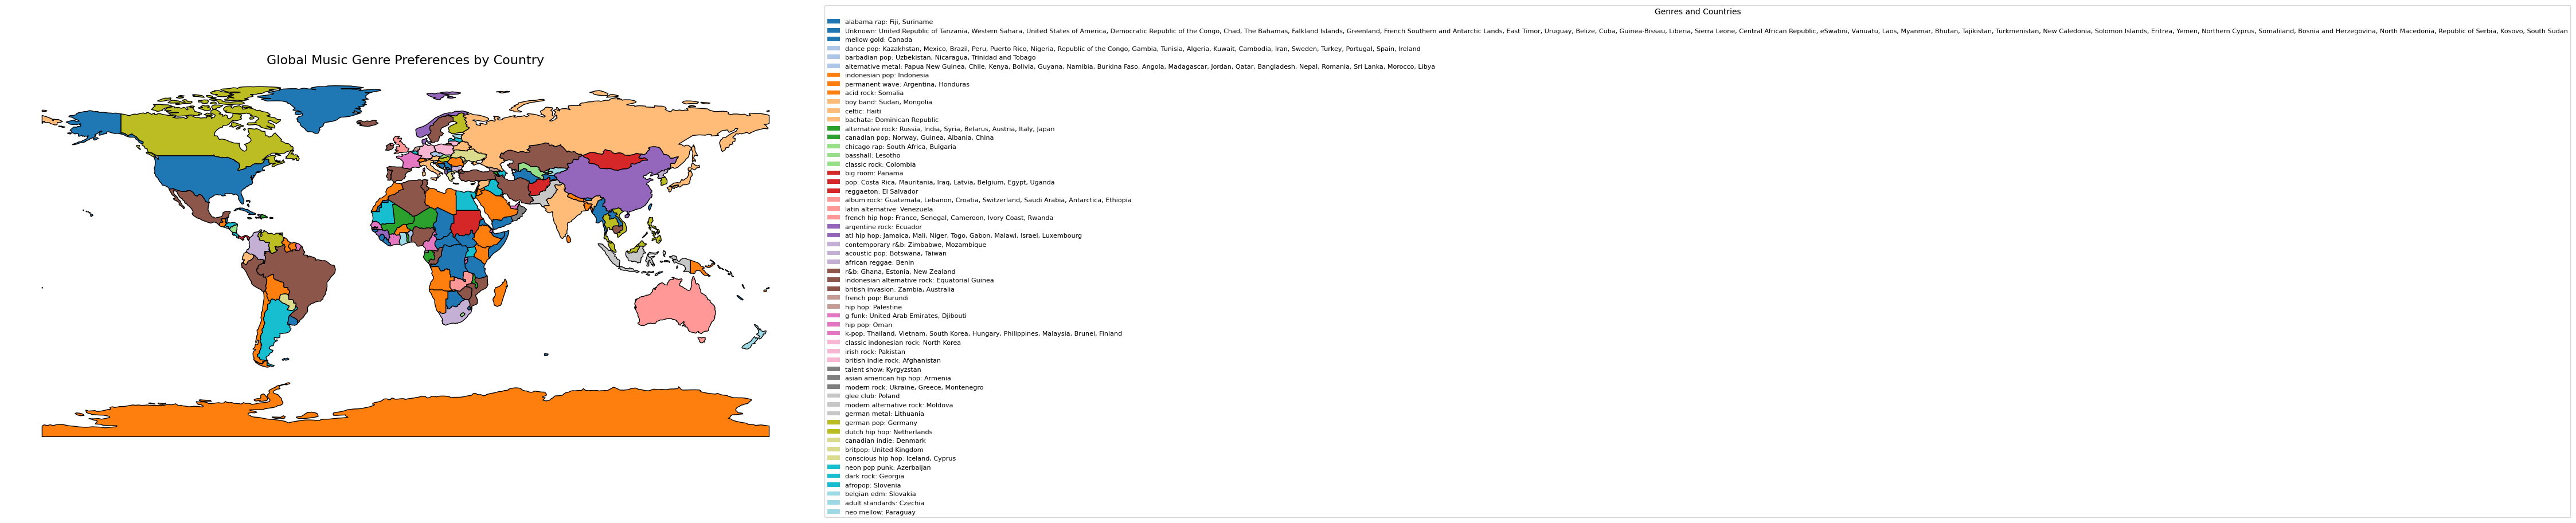

In [55]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1. Load the data
merged_file = r"C:\bigdatafinal\merged_tracks_tweets.csv"
world_shapefile = r"C:\bigdatafinal\ne_110m_admin_0_countries.shp"

merged_df = pd.read_csv(merged_file)
world = gpd.read_file(world_shapefile)

# 2. Set country information
merged_df['country'] = merged_df['countryName']
merged_df['country'] = merged_df['country'].fillna('Unknown')

# 3. Calculate the most preferred genre by country
top_genres_by_country = (
    merged_df.groupby(['country', 'artist_genres'])
    .size()
    .reset_index(name='count')
    .sort_values(['country', 'count'], ascending=[True, False])
)
top_genres_by_country = top_genres_by_country.drop_duplicates(subset='country', keep='first')
top_genres_by_country['main_genre'] = top_genres_by_country['artist_genres'].apply(
    lambda x: x.split(',')[0] if pd.notnull(x) else 'Unknown'
)

# 4. Merge the data
world_genres = world.merge(top_genres_by_country, how='left', left_on='ADMIN', right_on='country')
world_genres['main_genre'] = world_genres['main_genre'].fillna('Unknown')

# 5. Create a custom legend
# Extract genre and country information
legend_data = world_genres[['main_genre', 'ADMIN']].dropna()
unique_genres = legend_data['main_genre'].unique()

# Map colors to genres
color_map = plt.cm.get_cmap('tab20', len(unique_genres))
genre_colors = {genre: color_map(i) for i, genre in enumerate(unique_genres)}

# Generate custom legend entries
legend_elements = [
    Patch(
        facecolor=genre_colors[genre],
        label=f"{genre}: {', '.join(legend_data[legend_data['main_genre'] == genre]['ADMIN'].tolist())}"
    )
    for genre in unique_genres
]

# 6. Visualize the map
fig, ax = plt.subplots(figsize=(18, 12))
world_genres.plot(column='main_genre', cmap='tab20', edgecolor='black', ax=ax)

# Add the custom legend (positioned to the right of the map)
ax.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),  # Place the legend to the right of the map
    title='Genres and Countries',
    fontsize=8,
    title_fontsize=10
)

# Set map settings
ax.set_title('Global Music Genre Preferences by Country', fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()


In [56]:
# Calculate the number of occurrences for each song in the tweet dataset
song_popularity = merged_df.groupby('track_title').size().reset_index(name='tweet_count')

# Get the top 10 songs based on tweet count
top_10_songs = song_popularity.sort_values('tweet_count', ascending=False).head(10)

# Print the results
print("Top 10 most tweeted songs:")
print(top_10_songs)


Top 10 most tweeted songs:
                        track_title  tweet_count
30617              Someone Like You         4455
25442                      Paradise         3353
30583  Somebody That I Used to Know         3007
34225         The One That Got Away         2570
19447                        Levels         2568
29123          Set Fire to the Rain         2543
37791                 We Found Love         2341
35554                      Titanium         2117
38493           Where Have You Been         2083
5249                  Call Me Maybe         1993


In [57]:
# 1. Calculate the total tweet_count and average popularity for each track_title
song_popularity = (
    merged_df.groupby('track_title')
    .agg(tweet_count=('track_title', 'size'),  # Calculate the number of tweets
         avg_popularity=('popularity', 'mean'))  # Calculate the average popularity
    .reset_index()
)

# 2. Sort by tweet_count and retrieve the top 10 songs
top_10_songs = song_popularity.sort_values('tweet_count', ascending=False).head(10)

# Print the results
print("Top 10 songs based on tweet count and average popularity:")
print(top_10_songs)


Top 10 songs based on tweet count and average popularity:
                        track_title  tweet_count  avg_popularity
30617              Someone Like You         4455       76.443098
25442                      Paradise         3353       80.722040
30583  Somebody That I Used to Know         3007       73.350848
34225         The One That Got Away         2570       69.576265
19447                        Levels         2568       77.000000
29123          Set Fire to the Rain         2543       77.000000
37791                 We Found Love         2341       80.155062
35554                      Titanium         2117       67.980161
38493           Where Have You Been         2083       71.966395
5249                  Call Me Maybe         1993       71.000000


C:\Users\lovek\AppData\Local\Temp\ipykernel_1700\3118009551.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_10_songs['track_title'], rotation=45, ha='right')


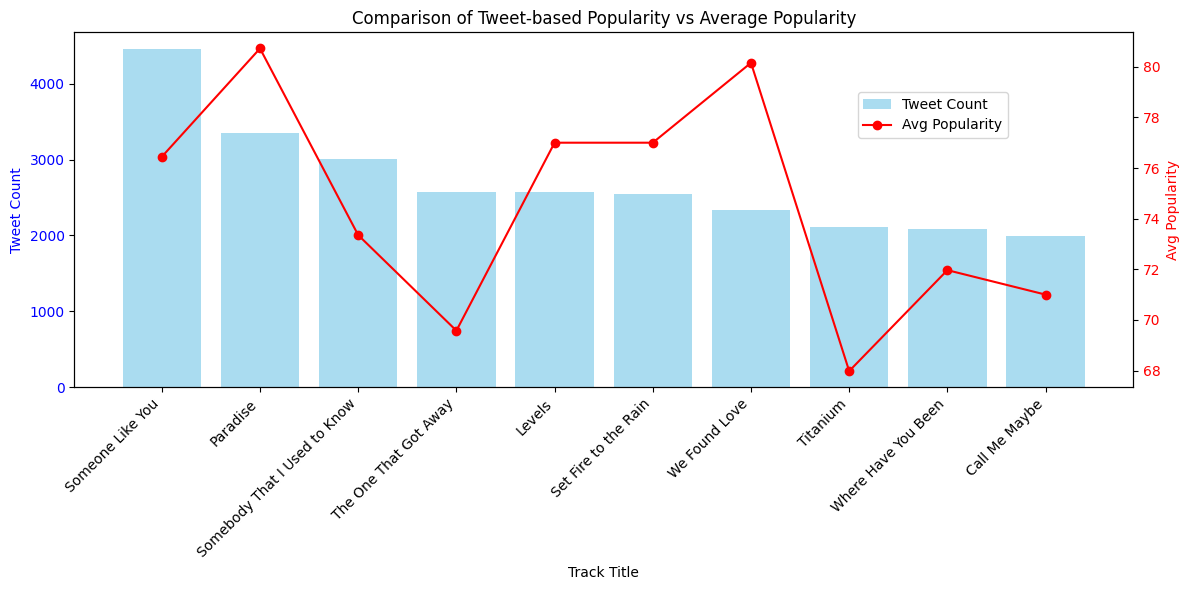

In [58]:
import matplotlib.pyplot as plt

# Prepare data for the top 10 songs
top_10_songs = song_popularity.sort_values('tweet_count', ascending=False).head(10)

# Create a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for tweet count (first axis)
ax1.bar(top_10_songs['track_title'], top_10_songs['tweet_count'], color='skyblue', alpha=0.7, label='Tweet Count')
ax1.set_xlabel('Track Title')
ax1.set_ylabel('Tweet Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(top_10_songs['track_title'], rotation=45, ha='right')

# Line chart for average popularity (second axis)
ax2 = ax1.twinx()
ax2.plot(top_10_songs['track_title'], top_10_songs['avg_popularity'], color='red', marker='o', label='Avg Popularity')
ax2.set_ylabel('Avg Popularity', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the title of the graph
plt.title('Comparison of Tweet-based Popularity vs Average Popularity')

# Add a legend
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd

# Set file paths
tweets_file = r"C:\bigdatafinal\mmtd.txt"  # 트윗 데이터 파일 경로
updated_tracks_file = r"C:\bigdatafinal\unique_tracks_info_updated.csv"  # 업데이트된 파일 경로
output_file = r"C:\bigdatafinal\update_merged_tracks_tweets.csv"  # 병합 결과 저장 경로

# Load datasets
tweets_df = pd.read_csv(tweets_file, sep='\t')  # Tab-separated tweets file
tracks_df = pd.read_csv(updated_tracks_file)  # Updated tracks file

# Merge tweets with updated tracks file on 'artist_name' and 'track_title'
merged_df = pd.merge(
    tweets_df,
    tracks_df,
    on=['artist_name', 'track_title'],
    how='inner'  # Only include matching rows
)

# Save merged results
merged_df.to_csv(output_file, index=False)
print(f"Merging complete! Result saved to: {output_file}")


Merging complete! Result saved to: C:\bigdatafinal\update_merged_tracks_tweets.csv


In [2]:
# Check umbrella_genre distribution
print(merged_df['umbrella_genre'].value_counts())


umbrella_genre
Unknown        472282
Pop             99676
Other           81737
Rock            55164
Hip Hop         45210
Metal           34508
R&B             13267
Soul             7270
Indie            7138
Electronic       6239
Alternative      5957
Country          5335
Reggae           3207
Jazz             1829
Folk             1744
Classical         372
Name: count, dtype: int64


C:\Users\lovek\AppData\Local\Temp\ipykernel_2748\3531747219.py:54: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  world_genres.plot(column='umbrella_genre', color=world_genres['umbrella_genre'].map(genre_colors), edgecolor='black', ax=ax)


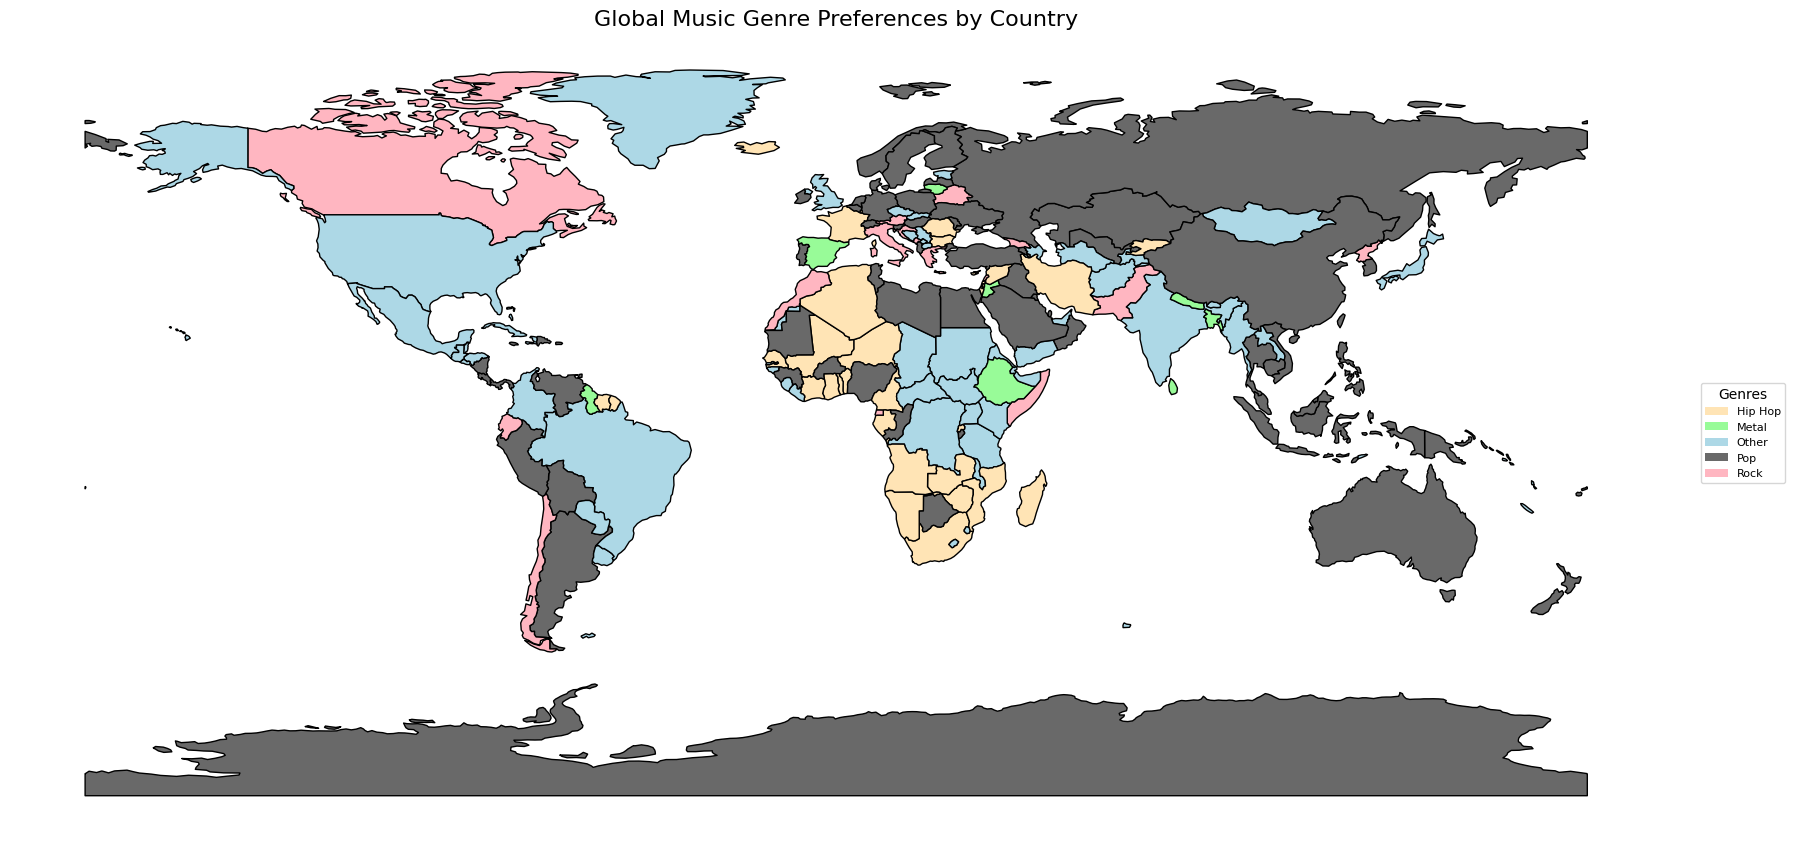

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import textwrap

# 1. Load the data
merged_file = r"C:\bigdatafinal\update_merged_tracks_tweets.csv"
world_shapefile = r"C:\bigdatafinal\ne_110m_admin_0_countries.shp"

# Load merged data and world shapefile
merged_df = pd.read_csv(merged_file)
world = gpd.read_file(world_shapefile)

# 2. Set country information
merged_df['country'] = merged_df['countryName'].fillna('Unknown')

# Exclude "Unknown" genres
merged_df = merged_df[merged_df['umbrella_genre'] != 'Unknown']

# 3. Calculate the most preferred genre by country
top_genres_by_country = (
    merged_df.groupby(['country', 'umbrella_genre'])
    .size()
    .reset_index(name='count')
    .sort_values(['country', 'count'], ascending=[True, False])
)
top_genres_by_country = top_genres_by_country.drop_duplicates(subset='country', keep='first')

# Normalize country names and merge
world['ADMIN'] = world['ADMIN'].str.lower()
top_genres_by_country['country'] = top_genres_by_country['country'].str.lower()
world_genres = world.merge(top_genres_by_country, how='left', left_on='ADMIN', right_on='country')
world_genres['umbrella_genre'] = world_genres['umbrella_genre'].fillna('Other')

# 4. Define a custom color palette
custom_colors = ["#FFE4B5", "#98FB98", "#ADD8E6", "#696969", "#FFB6C1"]  # 연주황색, 연녹색, 청록색, 갈색, 연핑크

# Create a color map for genres
unique_genres = sorted(world_genres['umbrella_genre'].dropna().unique())  # Drop any remaining NaNs
genre_colors = {genre: custom_colors[i % len(custom_colors)] for i, genre in enumerate(unique_genres)}

# Generate custom legend entries (only genres)
legend_elements = [
    Patch(
        facecolor=genre_colors[genre],
        label=genre  # Display only the genre name
    )
    for genre in unique_genres
]

# 5. Visualize the map
fig, ax = plt.subplots(figsize=(18, 12))
world_genres.plot(column='umbrella_genre', color=world_genres['umbrella_genre'].map(genre_colors), edgecolor='black', ax=ax)

# Add the custom legend
ax.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    title='Genres',
    fontsize=8,
    title_fontsize=10
)

# Set map settings
ax.set_title('Global Music Genre Preferences by Country', fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()



C:\Users\lovek\AppData\Local\Temp\ipykernel_18144\636494123.py:44: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  world_genres.plot(column='umbrella_genre', color=world_genres['umbrella_genre'].map(genre_colors), edgecolor='black', ax=ax)


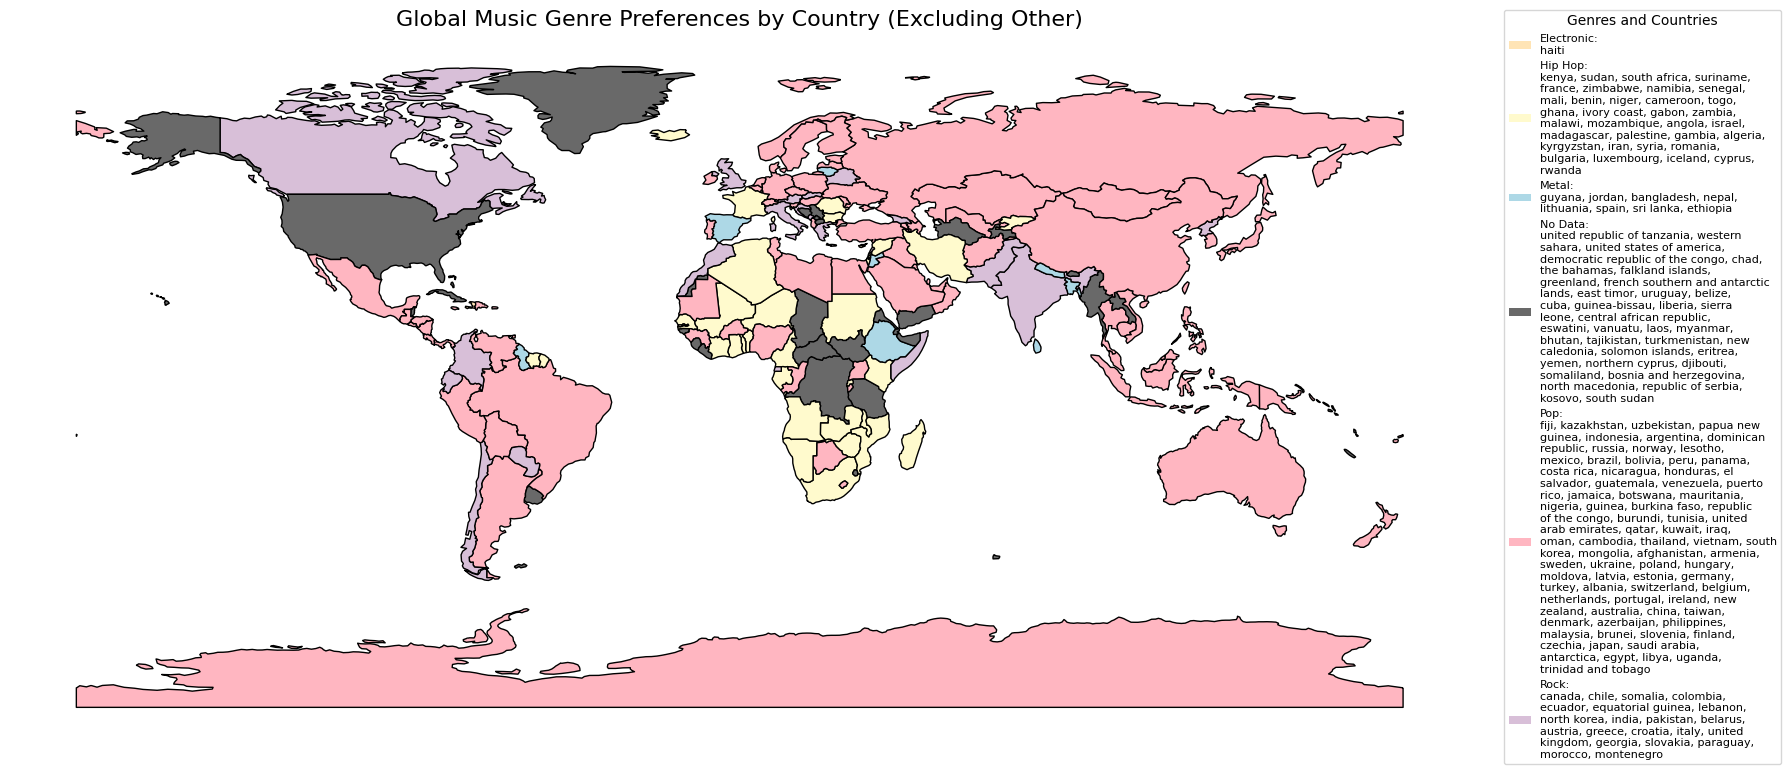

In [ ]:
# Exclude "Other" genres in the merged data
merged_df = merged_df[(merged_df['umbrella_genre'] != 'Unknown') & (merged_df['umbrella_genre'] != 'Other')]

# 3. Calculate the most preferred genre by country (excluding "Other")
top_genres_by_country = (
    merged_df.groupby(['country', 'umbrella_genre'])
    .size()
    .reset_index(name='count')
    .sort_values(['country', 'count'], ascending=[True, False])
)
top_genres_by_country = top_genres_by_country.drop_duplicates(subset='country', keep='first')

# Normalize country names and merge
world['ADMIN'] = world['ADMIN'].str.lower()
top_genres_by_country['country'] = top_genres_by_country['country'].str.lower()
world_genres = world.merge(top_genres_by_country, how='left', left_on='ADMIN', right_on='country')

# Fill missing genres with "No Data" instead of "Other"
world_genres['umbrella_genre'] = world_genres['umbrella_genre'].fillna('No Data')

# 4. Define a custom color palette
custom_colors = ["#FFE4B5", "#FFFACD", "#ADD8E6", "#696969", "#FFB6C1","#D8BFD8"] 

# Create a color map for genres
unique_genres = sorted(world_genres['umbrella_genre'].dropna().unique())  # Drop any remaining NaNs
genre_colors = {genre: custom_colors[i % len(custom_colors)] for i, genre in enumerate(unique_genres)}

# Map genres to countries with wrapped text
genre_country_map = world_genres.groupby('umbrella_genre')['ADMIN'].apply(
    lambda x: '\n'.join(textwrap.wrap(', '.join(x.dropna().unique()), width=40))
).to_dict()

# Generate custom legend entries
legend_elements = [
    Patch(
        facecolor=genre_colors[genre],
        label=f"{genre}:\n{genre_country_map[genre]}"
    )
    for genre in unique_genres
]

# 5. Visualize the map
fig, ax = plt.subplots(figsize=(18, 12))
world_genres.plot(column='umbrella_genre', color=world_genres['umbrella_genre'].map(genre_colors), edgecolor='black', ax=ax)

# Add the custom legend
ax.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    title='Genres and Countries',
    fontsize=8,
    title_fontsize=10
)

# Set map settings
ax.set_title('Global Music Genre Preferences by Country (Excluding Other)', fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()
